# Biomorphs

Loosely based on Richard Dawkins' biomorphs program, which he described in his book, *The Blind Watchmaker* <sup>[1]</sup> and articles such as *The Evolution of Evolvability* <sup>[2]</sup>, a pdf of which is in the folder with this notebook.

Much of the code in this notebook could be improved or optimised, especially the code for drawing the biomorphs, which is horribly slow, but unfortunately I have not found the time for making those kinds of improvements.

In lectures, I talk about how 3 main ingredients are required for evolution:

1. Inheritance (reproduction, or *copying*) 
2. Variation (through mutations, in this case)
3. Selection (in this case, the user of the program does the selection, not the program itself)

Dawkins' biomorphs are a relatively simple example of all of these ingredients at work.

When you run the code, you should see a matplotlib plot with 10 subplots. You might want to make it fill your screen before continuing. Every time you click on one of the biomorphs (which is an act of selection), that one will become the parent of the next generation. The parent will be copied 9 times, and every copy will be mutated, and then plotted in the remaining 9 subplots. Unfortunately, the matplotlib code for drawing the biomorphs is *really* slow, so you should be patient between selecting biomorphs to reproduce. 

## References
[1] Dawkins, R., 1996. *The blind watchmaker: Why the evidence of evolution reveals a universe without design.* WW Norton & Company.
<br>
[2] Dawkins, R. (1987). *The Evolution of Evolvability.* IEEE Symposium on Artificial Life.

## Encoding and decoding

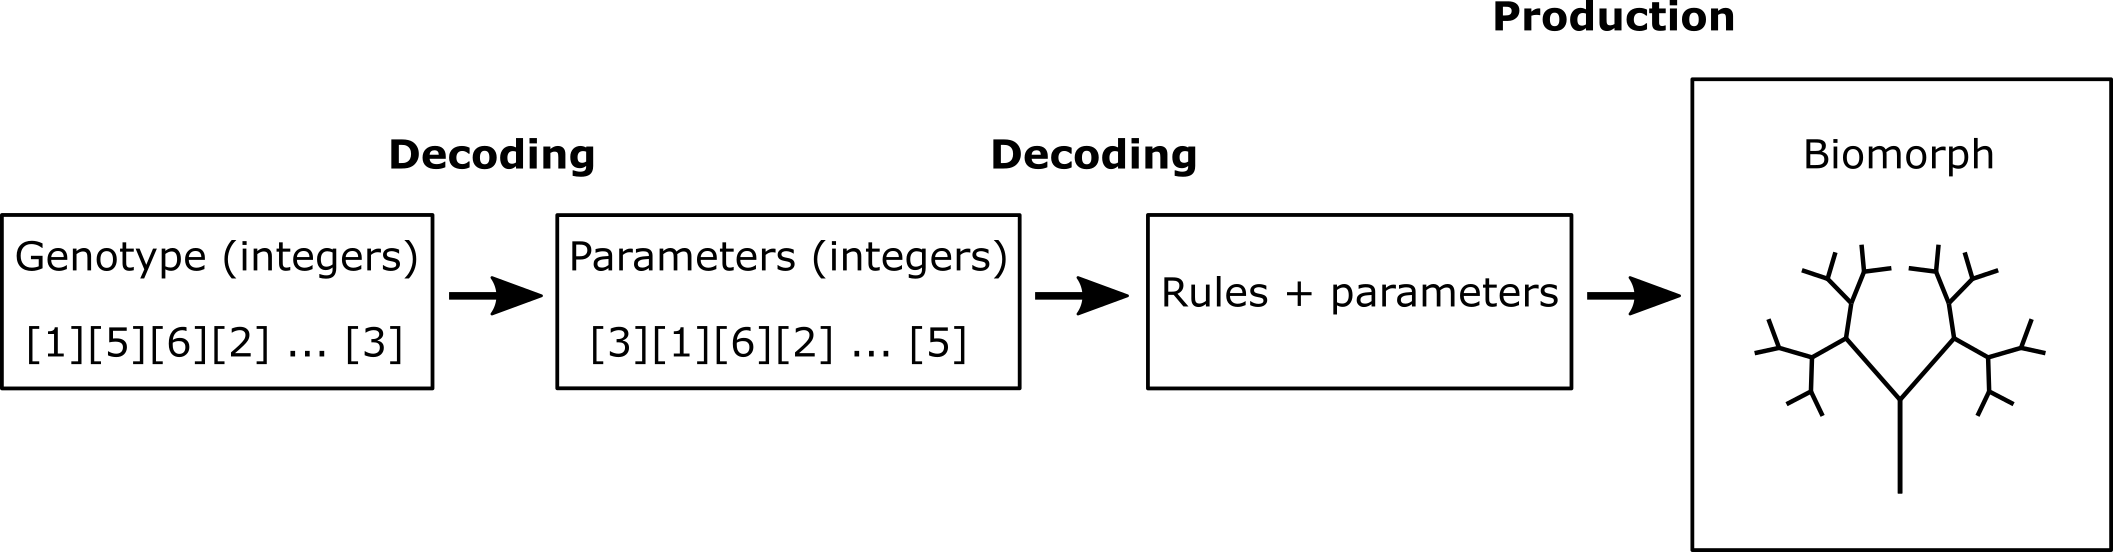

In artificial evolution, a genotype often encodes some parameters of the system or solution which is being evolved (or searched for via evolution, if you prefer). In these cases, we can say the the genotype directly encodes those parameters, as there will be some function which maps directly from the numbers in the genotype onto the numbers in the parameters. We can refer to this process as decoding the genotype.
Dawkins' approach to encoding Biomorphs is unusal in two resepects:
1. It has a double encoding (althouhgh it would be easy to merge the two encoding stages into a single one)
2. It combines direct and indirect encoding

The genotype is initially decoded into a list of parameters - a simple process, where the value from every gene in the list is placed in the list of parameters at least once, and some are used more than once. This step decodes a *direct encoding*. However, those parameters are not the parameters of a system - they are the parameters of the *rules of production* of the system. Essentially, Biomorphs are *grown* (recursively), according to fixed rules, for a number of stages specified in the genotype. In each stage of growth, parameters which are also specified in the genotype determine how the structure branches. Here, an *indirect encoding* is being decoded - the numbers in the genotype don't directly specify the shape of the biomorph in the way that we can specify the size of a circle with a radius parameter, or a rectangle with height and width parameters. 


## A short tangent - virtual creatures

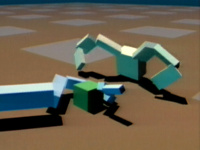


Indirect encodings are often used to evolve the morphologies (i.e. the shapes and properties of bodies) of virtual creatures and robots, as first seen in the groundbreaking example of Karl Sims' virtual creatures (https://www.karlsims.com/evolved-virtual-creatures.html, https://www.karlsims.com/). They are also used in neuroevolutionary algorithms such as NEAT (https://www.cs.ucf.edu/~kstanley/neat.html).

## Tangent over - back to biomorphs

In [1]:
%matplotlib tk

import numpy as np
from ipywidgets import widgets
from IPython.display import display
import copy
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton


## The `get_params` function

The `get_params` function takes a list of genes, or a *genotype*, and converts it into a list of parameters which can be used to construct a biomorph. This is a simple process of translation, or *decoding*. Often in artificial evolution, only one step of decoding is required. As explained above, because an indirect encoding is used here, there is a second step following this one, to map from the genotype to the phenotype (biomorph) that the genotype specifies.

In [2]:
def get_params(genes):
    dx = np.zeros(8)
    dy = np.zeros(8)
        
    dx[3] = genes[1]
    dx[4] = genes[2]
    dx[5] = genes[3]
    dx[1] = -dx[3]
    dx[0] = -dx[4]
    dx[2] = 0
    dx[6] = 0
    dx[7] = -dx[5]
    
    dy[2] = genes[4]
    dy[3] = genes[5]
    dy[4] = genes[6]
    dy[5] = genes[7]
    dy[6] = genes[8]
    dy[0] = dy[4]
    dy[1] = dy[3]
    dy[7] = dy[5]
    
    return genes[8], dx, dy

## The `biomorph` function

The `biomorph` function takes a list of parameters and constructs a biomorph using them. Together, the `get_params` and `biomorph` functions complete the mapping from a genotype to a *phenotype*. There are two things worth noting here: 

1. Biomorphs are encoded indirectly. Often, e.g. when evolving the weights and biases of a neural network, we can use a *direct* encoding, and simply copy the values from the vector of genes into the neural network's parameters. In this case, a biomorph is *grown* according to rules which were predetrmined by Dawkins, and the values from the genes specify things like the number of times to grow the biomorphs with new branches, and the directions in which the branches should grow.
2. This is a *recursive* function. You will see that in the last two lines of code in the function, it calls itself. This is a clever trick, which can be quite confusing the first time you see it. Essentially, what is does is add 2 branches to every branch it grows, until the specified number of iterations is completed. If you'd like me to explain this in more detail, please let me know.

In [3]:
def biomorph(x, y, length, direction, dx, dy, xbranches, ybranches, noise=True):
    # make directions "wrap around"
    if direction < 0:
        direction += 8
    elif direction >= 8:
        direction -= 8
    # compute end coordinates of new branch
    xnew = x + length * dx[direction]
    ynew = y + length * dy[direction]
    if noise:
        xnew += np.random.normal()
        ynew += np.random.normal()
    # add new branch to list
    xbranches.append([x, xnew])
    ybranches.append([y, ynew])
    # grow 2 new branches from the end of this one
    if length > 0:
        biomorph(xnew, ynew, length-1, direction-1, dx, dy, xbranches, ybranches, noise)
        biomorph(xnew, ynew, length-1, direction+1, dx, dy, xbranches, ybranches, noise)

## The `mutate_genotype` function

A function to mutate a genotype. This is where the variation ingredient of evolution is implemented. A genotype is a list of genes. In this application genes are integer values. The function will mutate ``n`` genes, shifting their values by an distance randomly drawn from the integer interval [``-power, power``], *not including 0* (because a zero mutation is not really a mutation at all).

In [4]:
def mutate_genotype(g, n=1, power=1, scale=20, order_min=3, order_max=6):
    # the sizes of mutations will be integers in the interval [-power:power], excluding 0
    choices = np.arange(power+1)[1:]
    choices = np.concatenate((-choices, choices))
    
    # get number of genes
    gene_num = len(g)

    # generate a list of all gene indices
    indices = np.arange(gene_num)
    # prepare a list of indices of genes to mutate
    mut_indices = []
    # the number of mutations will be either n or the number of genes in the genotype - whichever is greater
    mut_num = min(n, gene_num)
    # mutate the chosen number of genes
    for i in range(mut_num):
        # randomly choose a gene index
        ind = np.random.choice(indices)
        # remove the chosen gene index from the list so that it cannot be chosen again 
        indices = np.delete(indices, np.where(indices == ind))
        # add that gene index to the list of inidices of genes to mutate
        mut_indices.append(ind)
        
    # copy the genotype - use deep copy so that changing the genes of the copy will not also change the original
    temp = copy.deepcopy(g)

    # mutate genes
    for i in range(mut_num):
        # copy the genotype again, for mutating
        g2 = copy.deepcopy(temp)
        # loop until the genotype actually mutates 
        # - it is possible that a gene will not always change, e.g. if the gene is already at the limit +scale, 
        #   then a positive mutation will have no effect, as the gene cannot be increased further
        while np.array_equal(g2, temp):
            # select the amount to mutate the indexed gene by
            mut = np.random.choice(choices)
            
            if mut_indices[i] < gene_num-1:
                upper_lim = scale
                lower_lim = -scale
            else:
                upper_lim = order_max
                lower_lim = order_min
                mut = int(mut * (order_max-order_min) / (2*scale))
            
            # mutate the gene by the selected amount
            g2[mut_indices[i]] += mut
            # prevent the gene from being too large, in either positive or negative direction
            g2[mut_indices[i]] = min(upper_lim, g2[mut_indices[i]])
            g2[mut_indices[i]] = max(lower_lim, g2[mut_indices[i]])
        # copy the mutated genotype back into temp
        temp = g2
    
    # return mutated genotype
    return temp
        
            

## Genotype parameters

If you like biomorphs, then - as well as reading Dawkins' article - you might want to experiment with these parameters and see what different effects they have.

In [5]:
# this parameter determines the maximum magnitude of the genes in a genotype, which can all be either positive or negative, 
# except for the one that specifies the order parameter, which must be positive. 
scale = 20 
# unlike the others, the last gene must be positive, as it is the number of iterations to use when generating the biomorphs
# minimum number of iterations
order_min = 3
# maximum number of iterations
order_max = 9
# number of genes to mutate in each genotype
n_muts = 1
# maximum amount that a gene's value can change by. genes will mutate by integer distances drawn from [-mut_power, mut_power], excluding 0
mut_power = 20
# a parameter to turn a small amount of "noise" on when generating a biomorph
noise_ = True

## Setting up the plots 

The block of code below sets up the plots for evolving our biomorphs, and the initial 10 genotypes, which are generated randomly and then drawn. The lists of numbers above the plots are the genotypes which led to the production of the biomorphs the plots show. 
The on_click function is where the inheritance and selection ingredients of evolution are implemented. Every time you click on one of the plots, the biomorph shown there will be copied and mutated 9 times, and the new biomorphs will be drawn in the other 9 plots.

In [6]:
n_rows = 2
n_columns = 5
n_plots = n_rows * n_columns

fig, ax = plt.subplots(n_rows, n_columns)

# a list of genotypes, one for each subplot
genotypes = []
# a 1-d list of subplot axes, used for identifying which subplot has been clicked
flat_axes = []
# a list of subplot [row, column] indices, used for replotting biomorphs
flat_axes_inds = []

# set up the plots with random biomorphs
for i in range(n_plots):
    # generate 9 random values for the initial genotype
    genotype = np.random.randint(-scale, scale+1, 9)
    genotype[-1] = np.random.randint(order_min, order_max+1)
    length_, dx_, dy_ = get_params(genotype)
    # using lists means that when the lists are changed in the biomorph function, they will change here
    xbranches_ = []
    ybranches_ = []
    genotypes.append(genotype)
    # generate a biomorph
    biomorph(0, 0, length_, 2, dx_, dy_, xbranches_, ybranches_, noise_)
    
    # work out which axes (subplot) to put the biomorph in 
    row = 0
    column = 0
    if i > 0:
        row = int(i / n_columns)
        column = i - (row * n_columns)
    # keep records of the axes, and their position in the grid
    flat_axes.append(ax[row][column])
    flat_axes_inds.append([row, column])
    
    # plot the biomorph
    for xb, yb in zip(xbranches_, ybranches_):
        ax[row][column].plot([xb[0], xb[1]], [yb[0], yb[1]], 'k')
        
    # write the biomorph's genotype into the subplot's title
    ax[row][column].set_title(str(genotype), fontsize=9)

def on_click(event):
    # if the mouse is clicked
    if event.button is MouseButton.LEFT:
        # identify which axes were clicked on
        for i in range(n_plots):
            if event.inaxes == flat_axes[i]:
                ind = i
        
        # for all axes other than the one which is clicked on (which is the parent 
        # of the next generation), copy the parent, mutate, and draw 
        for i in range(n_plots):
            if i != ind:
                # copy and mutate parent to make child
                genotypes[i] = mutate_genotype(genotypes[ind], n_muts, mut_power, scale, order_min, order_max)
                # get biomorph parameters
                length_, dx_, dy_ = get_params(genotypes[i])
                xbranches_ = []
                ybranches_ = [] 
                # generate biomorph
                biomorph(0, 0, length_, 2, dx_, dy_, xbranches_, ybranches_, noise_)  
    
                # work out where the biomorph should be plotted
                row = flat_axes_inds[i][0] 
                column = flat_axes_inds[i][1]
                # clear subplot
                ax[row][column].cla()
                # plot biomorph!
                for xb, yb in zip(xbranches_, ybranches_):
                    ax[flat_axes_inds[i][0]][flat_axes_inds[i][1]].plot([xb[0], xb[1]], [yb[0], yb[1]], 'k')
                # set title of subplot to biomorph's genotype
                ax[flat_axes_inds[i][0]][flat_axes_inds[i][1]].set_title(str(genotypes[i]), fontsize=9)
        print()        
        fig.canvas.draw()
            
plt.connect('button_press_event', on_click)

            


14